# **Valorisation des entreprises Partie V**

Ce notebook est la suite du notebook `Valorisation_Entreprise_Data_Finpack_Parie_4`

Nous essayons de faire la classification des entreprises avec d'autres modèles

### **Packages**

In [1]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
#Sklearn
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score, classification_report, confusion_matrix, f1_score, log_loss, roc_curve, auc 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
#Keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, metrics, regularizers
from keras.utils import plot_model
#Pytorch
import torch
import torch.nn as nn
#
import graphviz
import plotly.express as px
import plotly.graph_objects as go  
from tqdm import tqdm
import time
import copy
import pickle

### **Data d'input**

In [2]:
#Importation les parties de description coder 
description_0_5000_coder = pd.read_excel ( 'Data Finpack V2/description_0_5000_coder.xlsx', index_col = 0 )

In [3]:
description_5000_10000_coder = pd.read_excel ( 'Data Finpack V2/description_5000_10000_coder.xlsx', index_col = 0 )

In [4]:
description_10000_15000_coder = pd.read_excel ( 'Data Finpack V2/description_10000_15000_coder.xlsx', index_col = 0 )

In [5]:
description_15000_17500_coder = pd.read_excel ( 'Data Finpack V2/description_15000_17500_coder.xlsx', index_col = 0 )

In [6]:
description_17500_21409_coder = pd.read_excel ( 'Data Finpack V2/description_17500_21409_coder.xlsx', index_col = 0 )

In [7]:
#Reconstruction de la df description
description_0_21409_coder = pd.concat( [description_0_5000_coder, description_5000_10000_coder, description_10000_15000_coder, description_15000_17500_coder, description_17500_21409_coder], axis = 0)
description_0_21409_coder

,business,products,services,summary,listed,stock,short,company's,production,engaged,...,operational,manage,achieved,insights,vitro,machineries,thousand,pfts,intelligent,dairy
22,1,1,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
30,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83676,1,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83681,1,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83687,1,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83690,1,0,0,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#Importation de data_normalzées
data_norm = pd.read_excel('Data Finpack V2/data_finpack_V2_sans_na_sans_out_norm.xlsx', index_col = 0)
data_norm = data_norm.drop ( ['Description'], axis = 1 )
data_norm

,Efcode,Company Name,Sector_Original,Country_Original,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,...,Days in acc. Pay. - Last,Days in Receiv. - Last,Sales To Receiv. - Last.1,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last
22,30031KN,11,Integrated Oil & Gas,NGA,0.517857,0.134328,-0.205479,1.682686,0.281579,1.882224,...,-0.164699,-0.551474,1.988124,0.732728,0.392183,0.213925,-0.275925,-0.184862,0.532646,0.512806
23,30145KN,ABC Transport PLC,Travel & Tourism,NGA,0.517857,0.835821,1.109589,-0.161432,-0.794737,0.568789,...,0.510024,-0.615530,1.861045,-0.120907,-0.181110,-0.194895,0.029715,-0.076419,-1.430241,0.213620
30,30268KN,Africa Prudential Plc,Investment Services,NGA,0.517857,0.164179,-0.219178,-0.201854,0.653947,-0.887504,...,-0.426269,1.438299,-0.288599,-0.165255,-0.124121,-0.120475,-0.701637,-0.747453,0.648110,-0.671129
35,30067KN,Aluminium Extrusion Industries PLC,Aluminum,NGA,0.517857,-0.761194,-0.041096,-0.193692,-0.294737,0.287621,...,-0.535694,-0.790203,113.292162,-0.158457,-0.197514,-0.183297,-0.399030,-0.219796,-0.380069,-0.296275
36,30033KN,Ardova Plc,Integrated Oil & Gas,NGA,0.517857,0.134328,7.794521,1.511816,-1.242105,1.611910,...,-0.130410,-0.546091,2.040380,-0.085894,0.394272,-0.121482,-0.620376,-0.556041,-4.599313,-0.699069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83676,30029AN,Millennium & Copthorne Hotels New Zealand Limited,Hotels,NZL,0.571429,0.059701,-0.219178,0.088098,-0.047368,-0.717512,...,-0.290800,-0.507469,1.393112,0.629732,0.718787,1.486135,1.471195,1.701601,-0.245361,0.021537
83681,40127AN,NZ Automotive Investments Ltd.,Specialty Retailers,NZL,0.571429,0.731343,0.643836,-0.066319,0.489474,1.489586,...,-0.684842,0.011977,0.709026,-0.058264,-0.172927,-0.163344,-0.151001,-0.251092,0.085223,0.346333
83687,30146AN,Neuren Pharmaceuticals Limited,Biotechnology,NZL,0.571429,-0.671642,-1.369863,-0.212575,-3.613158,-1.015694,...,-0.121417,-0.288925,0.289786,-0.186819,-0.154155,-0.095848,-1.249848,-1.197234,-0.450859,34.678696
83690,30021AN,New Zealand Oil & Gas Limited,Exploration & Production,NZL,0.571429,-0.223881,-0.630137,-0.040754,0.602632,-0.580375,...,-0.133408,-0.381779,0.686461,0.447747,0.153063,0.214946,2.214069,1.752547,0.403436,0.242724


In [9]:
#Importation des classes
entreprise_classe = pd.read_excel ( 'Data Finpack V2/entreprise_classe_V2.xlsx', index_col= 0 )
entreprise_classe = pd.merge ( entreprise_classe, description_0_21409_coder, right_index= True, left_index = True )
entreprise_classe

,Efcode,Company Name,Sector_Original,Country_Original,Sector,Country,EBITDA - Last,EBITDA Marg. (%) - Last,labels,business,...,operational,manage,achieved,insights,vitro,machineries,thousand,pfts,intelligent,dairy
9807,40838FC,Amulaire Thermal Technology Inc.,Heavy Construction,TWN,0.000000,1.000000,-0.312810,-2.180109,0,1,...,0,0,0,0,0,0,0,0,0,0
9836,30071FC,Hocheng Corporation,Building Materials & Fixtures,TWN,-0.611940,1.000000,0.187261,-0.129776,0,1,...,0,0,0,0,0,0,0,0,0,0
9856,30823FC,Longda Construction & Development Corp.,Heavy Construction,TWN,0.000000,1.000000,0.699601,0.718617,0,1,...,0,0,0,0,0,0,0,0,0,0
9885,30768FC,"Tung Kai Technology Engineering Co., Ltd.",Heavy Construction,TWN,0.000000,1.000000,-0.213853,-0.864767,0,1,...,0,0,0,0,0,0,0,0,0,0
9941,30209FC,Apex Science & Engineering Corp.,Electronic Equipment,TWN,-0.268657,1.000000,0.079980,-0.035779,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83437,30345EN,Intertrust NV,Specialty Finance,NLD,0.716418,0.535714,5.137368,1.345664,13,1,...,0,0,1,0,0,0,0,0,0,0
83524,90006EN,Royal BAM Groep NV,Heavy Construction,NLD,0.000000,0.535714,9.108747,-0.335961,13,1,...,1,0,0,0,0,0,0,0,0,0
83525,90032EN,Royal Boskalis Westminster N.V.,Heavy Construction,NLD,0.000000,0.535714,12.823483,0.290479,13,1,...,0,0,0,0,0,0,0,0,0,0
83573,30261EN,Yandex NV,Internet,NLD,0.149254,0.535714,15.010615,-0.155246,13,1,...,0,0,0,0,0,0,0,0,1,0


In [10]:
#Supprimons quelque variables pour libérer la mémoire 
del description_0_5000_coder
del description_5000_10000_coder
del description_10000_15000_coder
del description_15000_17500_coder
del description_17500_21409_coder

In [11]:
#Les colonnnes principales tu auras besoin dans l'extraction des classes
colonnes_principales = data_norm.columns
colonnes_principales = colonnes_principales.to_list ()
colonnes_principales.append ( 'labels' )
colonnes_principales

['Efcode',
 'Company Name',
 'Sector_Original',
 'Country_Original',
 'Country',
 'Sector',
 'Net Debt / Equity (x) - Last',
 'Net Sales - Last',
 'ROA - Last',
 'Sales To Assets (%) - Last',
 'Sales To Receiv. - Last',
 'Net Debt / Equity (x) - Last.1',
 'Fin. Debt / Equity (%) - 2020',
 'Fin. Debt / Assets (%) - 2020',
 'Fin. Debt / Equity (%) - Last',
 'Fin. Debt / Assets (%) - Last',
 'Net Debt / EBITDA (x) - Last',
 'Goodwill / Equity (%) - Last',
 'Fin. Debt / Assets (%) - 2020.1',
 'Sales To Assets (%) - Last.1',
 'Fin. Debt / Assets (%) - Last.1',
 'Current Ratio (%) - Last',
 'Days in Inventory - Last',
 'Days in acc. Pay. - Last',
 'Days in Receiv. - Last',
 'Sales To Receiv. - Last.1',
 'EBITDA - Last',
 'Total Assets - Last',
 'Sharehold. Equity - Last',
 'EBITDA Marg. (%) - Last',
 'EBIT Marg. (%) - Last',
 'ROE (%) - Last',
 'ROCE (%) - Last',
 'labels']

In [12]:
colonnes_clustering = ['Sector', 'Country', 'EBITDA - Last', 'EBITDA Marg. (%) - Last'] + description_0_21409_coder.columns.to_list()
colonnes_clustering

['Sector',
 'Country',
 'EBITDA - Last',
 'EBITDA Marg. (%) - Last',
 'business',
 'products',
 'services',
 'summary',
 'listed',
 'stock',
 'short',
 "company's",
 'production',
 'engaged',
 'limited',
 'development',
 'provides',
 'founded',
 'based',
 'taiwan',
 'offers',
 'established',
 'operates',
 'management',
 'exchange',
 'group',
 'equipment',
 'capital',
 'industrial',
 'public',
 'new',
 'shares',
 'construction',
 'market',
 'technology',
 'manufacture',
 'main',
 'tokyo',
 'systems',
 'investment',
 'power',
 'including',
 'incorporated',
 'manufacturing',
 'distribution',
 'companies',
 'solutions',
 'pt',
 'headquartered',
 'sales',
 'activities',
 'include',
 'mainly',
 'bombay',
 'changed',
 'llc',
 'industry',
 'wvb',
 'related',
 'real',
 'summarythe',
 'plant',
 'service',
 'sells',
 'high',
 'delaware',
 'engages',
 'sale',
 'million',
 'design',
 'subsidiary',
 'estate',
 'berhad',
 'india.wvb',
 'international',
 'china',
 'holding',
 'activity',
 'ab',
 'appo

### **Classification supérvisée**

#### Data d'input

In [13]:
#Changement de la position de la colonne labels
labels = entreprise_classe.labels
entreprise_classe_ = pd.concat ([entreprise_classe.drop ('labels', axis =1), labels], axis = 1)
entreprise_classe_

,Efcode,Company Name,Sector_Original,Country_Original,Sector,Country,EBITDA - Last,EBITDA Marg. (%) - Last,business,products,...,manage,achieved,insights,vitro,machineries,thousand,pfts,intelligent,dairy,labels
9807,40838FC,Amulaire Thermal Technology Inc.,Heavy Construction,TWN,0.000000,1.000000,-0.312810,-2.180109,1,1,...,0,0,0,0,0,0,0,0,0,0
9836,30071FC,Hocheng Corporation,Building Materials & Fixtures,TWN,-0.611940,1.000000,0.187261,-0.129776,1,1,...,0,0,0,0,0,0,0,0,0,0
9856,30823FC,Longda Construction & Development Corp.,Heavy Construction,TWN,0.000000,1.000000,0.699601,0.718617,1,0,...,0,0,0,0,0,0,0,0,0,0
9885,30768FC,"Tung Kai Technology Engineering Co., Ltd.",Heavy Construction,TWN,0.000000,1.000000,-0.213853,-0.864767,1,1,...,0,0,0,0,0,0,0,0,0,0
9941,30209FC,Apex Science & Engineering Corp.,Electronic Equipment,TWN,-0.268657,1.000000,0.079980,-0.035779,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83437,30345EN,Intertrust NV,Specialty Finance,NLD,0.716418,0.535714,5.137368,1.345664,1,0,...,0,1,0,0,0,0,0,0,0,13
83524,90006EN,Royal BAM Groep NV,Heavy Construction,NLD,0.000000,0.535714,9.108747,-0.335961,1,1,...,0,0,0,0,0,0,0,0,0,13
83525,90032EN,Royal Boskalis Westminster N.V.,Heavy Construction,NLD,0.000000,0.535714,12.823483,0.290479,1,0,...,0,0,0,0,0,0,0,0,0,13
83573,30261EN,Yandex NV,Internet,NLD,0.149254,0.535714,15.010615,-0.155246,1,1,...,0,0,0,0,0,0,0,1,0,13


In [14]:
i = 10000
entreprise_classe_.loc[i:i]

,Efcode,Company Name,Sector_Original,Country_Original,Sector,Country,EBITDA - Last,EBITDA Marg. (%) - Last,business,products,...,manage,achieved,insights,vitro,machineries,thousand,pfts,intelligent,dairy,labels
10000,31851FC,CUPRIME MATERIAL,Electrical Components & Equipment,TWN,-0.298507,1.0,-0.11205,-0.556095,1,0,...,0,0,0,0,0,0,0,0,0,12


In [15]:
#Mélanger les données 
data_shuffled = entreprise_classe_.sample ( frac = 1, random_state = 42 )
data_shuffled

,Efcode,Company Name,Sector_Original,Country_Original,Sector,Country,EBITDA - Last,EBITDA Marg. (%) - Last,business,products,...,manage,achieved,insights,vitro,machineries,thousand,pfts,intelligent,dairy,labels
63659,33016FI,Steelcast Ltd.,Iron & Steel,IND,0.179104,0.000000,0.181689,0.805943,1,1,...,0,0,0,0,0,0,0,0,0,3
52709,49412PC,JIANGSU BOJI SPRAYING SYSTEMS,Industrial Machinery,CHN,0.089552,-0.392857,-0.113849,-0.152820,1,1,...,0,0,0,0,0,0,0,0,0,11
63154,80042FI,Mercantile Ventures Ltd,Real Estate Holding & Development,IND,0.507463,0.000000,-0.107337,4.104912,1,0,...,0,0,0,0,0,0,0,0,0,7
61884,30436ED,artnet AG,Specialty Retailers,DEU,0.731343,-0.267857,-0.167283,-0.682838,1,1,...,0,0,0,0,0,0,0,0,0,4
55339,55274PC,"Jiangsu Hanvo Safety Product Co., Ltd.",Medical Equipment,CHN,0.238806,-0.392857,0.391048,0.417829,1,1,...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59101,30079LE,Compania de Economia Mxt Prq Indstrl Rbm,Food Products,ECU,-0.164179,-0.250000,20.949355,-0.319588,1,1,...,0,0,0,0,0,0,0,0,1,6
30382,40437FU,West Coach Station JSC,Trucking,VNM,0.850746,1.142857,-0.121711,1.984233,1,0,...,0,0,0,0,0,0,0,0,0,7
541,30001GO,Al Anwar Ceramic Tiles Co.,Building Materials & Fixtures,OMN,-0.611940,0.589286,0.219794,0.658581,1,1,...,0,0,0,0,0,0,0,0,0,4
73591,31799FJ,"Helios Techno Holding Co., Ltd.",Electrical Components & Equipment,JPN,-0.298507,0.142857,-0.049542,-0.188599,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#Nombre d'entreprise dans chaque classe 
print ('''Nombre d'entreprise dans chaque classe :\n''',  entreprise_classe_.labels.value_counts())

Nombre d'entreprise dans chaque classe :
 4     4436
12    2403
0     2197
2     1707
11    1674
10    1474
13    1275
5     1223
9     1045
7     1041
8     1012
3      974
6      488
1      438
Name: labels, dtype: int64


In [17]:
#### X et y ################################################################################################

X = data_shuffled.drop( ['Efcode', 'Company Name','Sector_Original', 'Country_Original', 'labels'], axis =1 )
y = data_shuffled.labels
X
############################################################################################################

,Sector,Country,EBITDA - Last,EBITDA Marg. (%) - Last,business,products,services,summary,listed,stock,...,operational,manage,achieved,insights,vitro,machineries,thousand,pfts,intelligent,dairy
63659,0.179104,0.000000,0.181689,0.805943,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
52709,0.089552,-0.392857,-0.113849,-0.152820,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
63154,0.507463,0.000000,-0.107337,4.104912,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
61884,0.731343,-0.267857,-0.167283,-0.682838,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
55339,0.238806,-0.392857,0.391048,0.417829,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59101,-0.164179,-0.250000,20.949355,-0.319588,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
30382,0.850746,1.142857,-0.121711,1.984233,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
541,-0.611940,0.589286,0.219794,0.658581,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
73591,-0.298507,0.142857,-0.049542,-0.188599,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#Transformons les labes des classes vers 0 1 2 ... 9
'''y[y == 2] = 1
y[y == 16] = 2
y[y == 21] = 3
y[y == 22] = 4
y[y == 23] = 5
y[y == 30] = 6
y[y == 31] = 7
y[y == 32] = 8
y[y == 33] = 9
y.value_counts()'''

'y[y == 2] = 1\ny[y == 16] = 2\ny[y == 21] = 3\ny[y == 22] = 4\ny[y == 23] = 5\ny[y == 30] = 6\ny[y == 31] = 7\ny[y == 32] = 8\ny[y == 33] = 9\ny.value_counts()'

In [18]:
#X_train, y_train,X_validation, y_validation, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split ( X, y ,stratify = y , train_size = 0.93 )
X_train, X_validation, y_train, y_validation = train_test_split ( X_train, y_train, stratify = y_train, train_size = 0.93 )
print ('data train')
print ( 'la taille de X_train :', X_train.shape )
print ( 'la taille de y_train :', y_train.shape )
print ('data cross validation')
print ( 'la taille de X_validation :', X_validation.shape )
print ( 'la taille de y_validation :', y_validation.shape )
print ('data test')
print ( 'la taille de X_test :', X_test.shape )
print ( 'la taille de y_test :', y_test.shape )

data train
la taille de X_train : (18496, 2002)
la taille de y_train : (18496,)
data cross validation
la taille de X_validation : (1393, 2002)
la taille de y_validation : (1393,)
data test
la taille de X_test : (1498, 2002)
la taille de y_test : (1498,)


In [19]:
#Nombre d'enreprise dans chaque portion de la data groupée par classe
nbr_cmp_train = pd.DataFrame ([y_train.value_counts()], index = ['data_train']).T
nbr_cmp_test  = pd.DataFrame ([y_test.value_counts()], index = ['data_test']).T
pd.concat ( [nbr_cmp_train, nbr_cmp_test], axis = 1 )

,data_train,data_test
4,3836,311
12,2078,168
0,1900,154
2,1476,120
11,1448,117
10,1275,103
13,1103,89
5,1057,86
9,904,73
7,900,73


In [40]:
#caracteristiques_financieres =pd.DataFrame ( X_train.columns.tolist() )
#caracteristiques_financieres.to_excel( 'Data Finpack/caracteristiques_financieres.xlsx', index = False )

#### Gradient Boosting

|Entrainnement par batches|
-----------------------------

In [ ]:
#Entrainnement par batches 
classes = [ 0,  2, 16, 21, 22, 23, 30, 31, 32, 33,]
model_gradient_boosting = GradientBoostingClassifier ( loss = 'log_loss' )
num_iter = 20
train_batch_size = X_train.shape[0]//num_iter 
print ('train_batch_size ', train_batch_size)
validation_batch_size = X_validation.shape [0]//num_iter 
print ('test_batch_size ', validation_batch_size)
#accuracy_train = []
#accuracy_test = []
log_loss_train = []
log_loss_validation = []
for i in range ( num_iter ):
    X_train_batch = X_train [ i*train_batch_size :  (i+1)*train_batch_size]
    y_train_batch = y_train [ i*train_batch_size :  (i+1)*train_batch_size  ]

    X_validation_batch = X_validation [ i*validation_batch_size : (i+1) * validation_batch_size ]
    y_validation_batch = y_validation [ i*validation_batch_size : (i+1) * validation_batch_size  ]

    model_gradient_boosting.fit ( X_train_batch, y_train_batch)

    #accuracy_train.append ( model_decision_tree.score( X_train, y_train ) )
    #accuracy_test.append ( model_decision_tree.score ( X_validation, y_validation ) )

    y_train_pred = model_gradient_boosting.predict_proba ( X_train )
    y_validation_pred = model_gradient_boosting.predict_proba ( X_validation )

    log_loss_train.append ( log_loss ( y_train, y_train_pred, labels = classes ) )
    log_loss_validation.append ( log_loss ( y_validation, y_validation_pred, labels = classes ) )

    print ( 'Términé pour : ', (i+1)*train_batch_size ,'Entreprises')


log_loss_df = pd.DataFrame({'num_iter': range (num_iter), 'log_loss_train': log_loss_train, 'log_loss_validation': log_loss_validation})
fig = px.line ( log_loss_df, x = 'num_iter', y = ['log_loss_train', 'log_loss_validation'], width = 700, height = 500 )
fig.update_layout ( title = '''evolution du log_loss en fct du nombre d'itération''' )
fig.show()

train_batch_size  918
test_batch_size  69
Términé pour :  918 Entreprises
Términé pour :  1836 Entreprises
Términé pour :  2754 Entreprises
Términé pour :  3672 Entreprises
Términé pour :  4590 Entreprises
Términé pour :  5508 Entreprises
Términé pour :  6426 Entreprises
Términé pour :  7344 Entreprises
Términé pour :  8262 Entreprises
Términé pour :  9180 Entreprises
Términé pour :  10098 Entreprises
Términé pour :  11016 Entreprises
Términé pour :  11934 Entreprises
Términé pour :  12852 Entreprises
Términé pour :  13770 Entreprises
Términé pour :  14688 Entreprises
Términé pour :  15606 Entreprises
Términé pour :  16524 Entreprises
Términé pour :  17442 Entreprises
Términé pour :  18360 Entreprises


|Initialisation du model|
------------------

In [ ]:
model_gradient_boosting = GradientBoostingClassifier ( n_estimators = 250 )
model_gradient_boosting.fit (X_train, y_train)

GradientBoostingClassifier(n_estimators=250)

In [ ]:
y_train_predicted = model_gradient_boosting.predict ( X_train )
print ( 'y_train :\n ', y_train )
print ( 'y_train_predicted :\n', y_train_predicted )

y_train :
  10823    23
6935      0
14459     2
15125    33
10288     0
         ..
20069     2
12765     0
16738    31
4669     22
1794      0
Name: labels, Length: 19763, dtype: int64
y_train_predicted :
 [23  0  2 ... 31 22  0]


In [ ]:
print ( 'accuracy du model Gradient Boosting sur les données dentrainnemnt ', accuracy_score ( y_train, y_train_predicted ) )

accuracy du model Gradient Boosting sur les données dentrainnemnt  0.9859333097201842


In [ ]:
y_test_predicted = model_gradient_boosting.predict ( X_test )
print ( 'y_test : \n', y_test )
print ( 'y_test_predicted : \n', y_test_predicted )


y_test : 
 7065      0
1654     31
17350     0
6755     23
18254     0
         ..
14701    16
10099    16
1822     30
17001    32
13396     0
Name: labels, Length: 1488, dtype: int64
y_test_predicted : 
 [16 31  0 ... 30 32  0]


In [ ]:
#accuracy sur les données test
print ( 'accuracy sur les données test :', accuracy_score( y_test, y_test_predicted ) )

accuracy sur les données test : 0.9260752688172043


Text(50.722222222222214, 0.5, 'True labels')

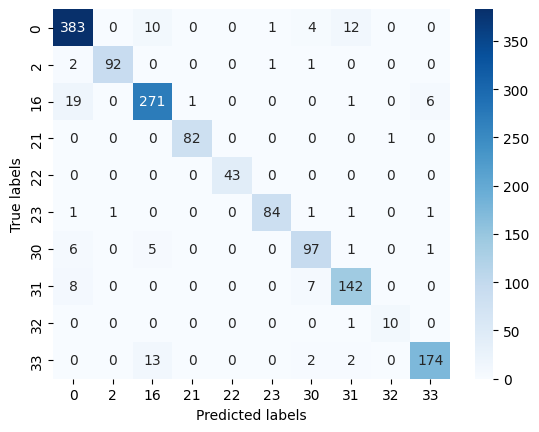

In [ ]:
#Matrice de confusion
classes = [ 0, 2, 16, 21, 22, 23, 30, 31, 32, 33 ]
matrice_confusion = confusion_matrix ( y_test, y_test_predicted )
fig15 = sns.heatmap ( matrice_confusion, annot = True, fmt = 'd', cmap = 'Blues' )
fig15.set_xticklabels ( classes )
fig15.set_yticklabels ( classes )
fig15.set_xlabel ( 'Predicted labels' )
fig15.set_ylabel ( 'True labels' )

In [ ]:
#top 3 accuracy du modèle 
from top_accuracy_V0 import top_accuracy

predictions = model_gradient_boosting.predict_proba  (X_test)
print ( 'top 3 accuracy du modèle gradient descent = ', top_accuracy ( predictions, np.array (y_test), classes, top_i = 3 ) )

total =  1488
top 3  = 1486
top 3 accuracy du modèle gradient descent =  99.86559139784946


In [ ]:
#Le F1 score 
print ( 'F1-score test Micro =', f1_score ( y_test, y_test_predicted, average = 'micro' ) )
print ( 'F1-score test Macro =', f1_score ( y_test, y_test_predicted, average = 'macro' ) )
print ( 'F1-score test Weighted =', f1_score ( y_test, y_test_predicted, average = 'weighted' ) )

F1-score test Micro = 0.9260752688172043
F1-score test Macro = 0.9365214010587997
F1-score test Weighted = 0.9262560674499984


|La courbe ROC|
-------------

c:\Users\hh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\hh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\hh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\hh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\hh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: 

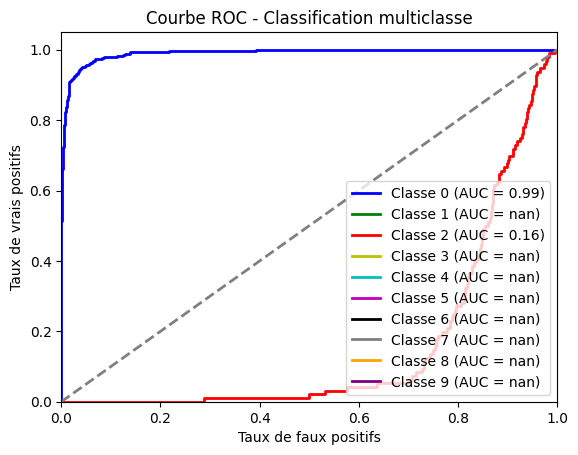

In [ ]:
#Prediction probabilité
y_test_predictproba = model_gradient_boosting.predict_proba( X_test )
y_test_predictproba

taux_vraies_positives = dict()
taux_faux_positives = dict()
roc_auc = dict ()

#Calcule des taux vraies positives et taux faux positives
for i in range(len(y_test_predictproba[0])):
    taux_faux_positives[i], taux_vraies_positives[i], _ = roc_curve(y_test, y_test_predictproba[:, i], pos_label=i)
    roc_auc[i] = auc( taux_faux_positives[i], taux_vraies_positives[i] )


#ploting figure
plt.figure()
colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', 'gray', 'orange', 'purple']  # Couleurs pour chaque classe
for i in range(len(y_test_predictproba[0])):
    plt.plot( taux_faux_positives[i], taux_vraies_positives[i], color=colors[i], lw=2, label='Classe %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Classification multiclasse')
plt.legend(loc="lower right")
plt.show()

#### Descision Tree

In [20]:
X_train

,Sector,Country,EBITDA - Last,EBITDA Marg. (%) - Last,business,products,services,summary,listed,stock,...,operational,manage,achieved,insights,vitro,machineries,thousand,pfts,intelligent,dairy
60847,0.328358,-0.142857,-0.100082,-0.272893,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
71,-0.164179,0.517857,4.638188,0.682838,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
48205,-0.492537,-0.392857,0.127044,0.414190,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
74652,0.402985,0.142857,0.668176,-0.041844,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10403,-0.298507,1.000000,2.450055,-0.019406,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47758,0.656716,-0.392857,0.174521,0.915100,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0
9980,-0.298507,1.000000,0.060716,1.180109,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
74456,0.776119,0.142857,13.207761,0.208611,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3669,-0.223881,0.767857,25.004321,1.482717,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Search Grid
param_grid = { 'min_samples_leaf' : [ 2, 3, 4, 5, 6, 7] }

search_grid = GridSearchCV ( DecisionTreeClassifier(), param_grid, cv = 5 )
search_grid.fit ( X_train, y_train )
print ( 'La meilleure valeur du  est : ',  search_grid.best_params_)

La meilleure valeur du max_depth est :  {'min_samples_leaf': 6}


In [ ]:
#Entrainnement par batches
labels= [ 0,  2, 16, 21, 22, 23, 30, 31, 32, 33,]
model_decision_tree = DecisionTreeClassifier ( criterion = 'gini', max_depth = 22, min_samples_leaf = 5 )
num_iter = 49
train_batch_size = X_train.shape[0]//num_iter 
print ('train_batch_size ', train_batch_size)
validation_batch_size = X_validation.shape [0]//num_iter 
print ('test_batch_size ', validation_batch_size)
#accuracy_train = []
#accuracy_test = []
log_loss_train = []
log_loss_validation = []
for i in range ( num_iter ):
    X_train_batch = X_train [ i*train_batch_size :  (i+1)*train_batch_size]
    y_train_batch = y_train [ i*train_batch_size :  (i+1)*train_batch_size  ]

    X_validation_batch = X_validation [ i*validation_batch_size : (i+1) * validation_batch_size ]
    y_validation_batch = y_validation [ i*validation_batch_size : (i+1) * validation_batch_size  ]

    model_decision_tree.fit ( X_train_batch, y_train_batch)

    #accuracy_train.append ( model_decision_tree.score( X_train, y_train ) )
    #accuracy_test.append ( model_decision_tree.score ( X_validation, y_validation ) )

    y_train_pred = model_decision_tree.predict_proba ( X_train )
    y_validation_pred = model_decision_tree.predict_proba ( X_validation )

    log_loss_train.append ( log_loss ( y_train, y_train_pred, labels = labels ) )
    log_loss_validation.append ( log_loss ( y_validation, y_validation_pred, labels = labels ) )

    print ( 'Términé pour : ', (i+1)*train_batch_size ,'Entreprises')


log_loss_df = pd.DataFrame({'num_iter': range (num_iter), 'log_loss_train': log_loss_train, 'log_loss_validation': log_loss_validation})
fig = px.line ( log_loss_df, x = 'num_iter', y = ['log_loss_train', 'log_loss_validation'], width = 700, height = 500 )
fig.update_layout ( title = '''log_loss en fct du nombre d'itération''' )
fig.show()


train_batch_size  375
test_batch_size  28
Términé pour :  375 Entreprises
Términé pour :  750 Entreprises
Términé pour :  1125 Entreprises
Términé pour :  1500 Entreprises
Términé pour :  1875 Entreprises
Términé pour :  2250 Entreprises
Términé pour :  2625 Entreprises
Términé pour :  3000 Entreprises
Términé pour :  3375 Entreprises
Términé pour :  3750 Entreprises
Términé pour :  4125 Entreprises
Términé pour :  4500 Entreprises
Términé pour :  4875 Entreprises
Términé pour :  5250 Entreprises
Términé pour :  5625 Entreprises
Términé pour :  6000 Entreprises
Términé pour :  6375 Entreprises
Términé pour :  6750 Entreprises
Términé pour :  7125 Entreprises
Términé pour :  7500 Entreprises
Términé pour :  7875 Entreprises
Términé pour :  8250 Entreprises
Términé pour :  8625 Entreprises
Términé pour :  9000 Entreprises
Términé pour :  9375 Entreprises
Términé pour :  9750 Entreprises
Términé pour :  10125 Entreprises
Términé pour :  10500 Entreprises
Términé pour :  10875 Entreprises


|Initialisation du model|
------------------------

In [93]:
#Initialisaiton et entrainnement du model du model
#criterion = 'gini', min_samples_leaf = 5
model_decision_tree = DecisionTreeClassifier(min_samples_leaf = 8, max_depth = 5)
model_decision_tree.fit ( X_train, y_train )

DecisionTreeClassifier(max_depth=5, min_samples_leaf=8)

In [94]:
#Train
y_train_predicted = model_decision_tree.predict ( X_train )
#print ( 'y_train ', y_train )
#print ( 'X_train_predicted ', y_train_predicted )
#Accuracy sur les données d'entrainnement 
print ( ''' Accuracy sur les données d'entrainnement ''', accuracy_score ( y_train, y_train_predicted )  )
#Test
y_test_predicted = model_decision_tree.predict ( X_test )
#print ( 'y_test ', y_test )
#print ( 'y_test_predicted ', y_test_predicted )
#Accuracy sur les données test
print ( 'Accuracy sur les données test : ', accuracy_score ( y_test, y_test_predicted ) )
#F1 score
print ( 'F1-score sur datatest : ', f1_score ( y_test, y_test_predicted, average = 'macro' )  )

 Accuracy sur les données d'entrainnement  0.639435553633218
Accuracy sur les données test :  0.6234979973297731
F1-score sur datatest :  0.5739261691004874


In [23]:
#Log loss sur les données d'entrainnement
y_train_predicted_proba = model_decision_tree.predict_proba ( X_train )
print ( 'log loss sur les données dentrainnement :', log_loss(y_train, y_train_predicted_proba,  labels= [ 0,  2, 16, 21, 22, 23, 30, 31, 32, 33,]))

ValueError: The number of classes in labels is different from that in y_pred. Classes found in labels: [ 0  2 16 21 22 23 30 31 32 33]

ValueError: The number of FixedLocator locations (14), usually from a call to set_ticks, does not match the number of ticklabels (10).

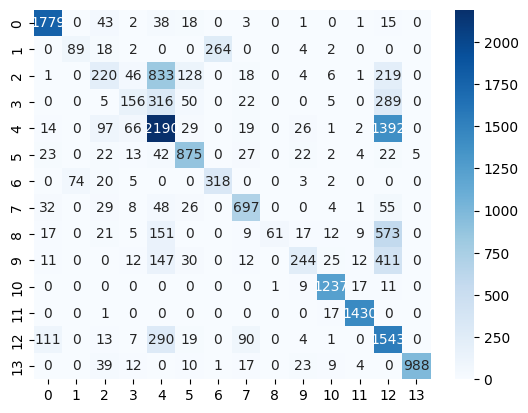

In [95]:
#Matrice de confusion sur les données d'entrainnement
labels = [0, 2, 16, 21, 22, 23, 30, 31, 32, 33]
matrice_confusion_train = confusion_matrix (y_train, y_train_predicted)
fig2 = sns.heatmap ( matrice_confusion_train, annot = True, fmt = 'd', cmap = 'Blues' )
fig2.set_xticklabels (labels)
fig2.set_yticklabels (labels)

In [26]:
#Log loss sut les données test
y_test_predicted_proba = model_decision_tree.predict_proba ( X_test )
print ( 'log loss sur les données test :', log_loss(y_test, y_test_predicted_proba,  labels= [ 0,  2, 16, 21, 22, 23, 30, 31, 32, 33,]))

ValueError: The number of classes in labels is different from that in y_pred. Classes found in labels: [ 0  2 16 21 22 23 30 31 32 33]

Text(50.722222222222214, 0.5, 'True lables')

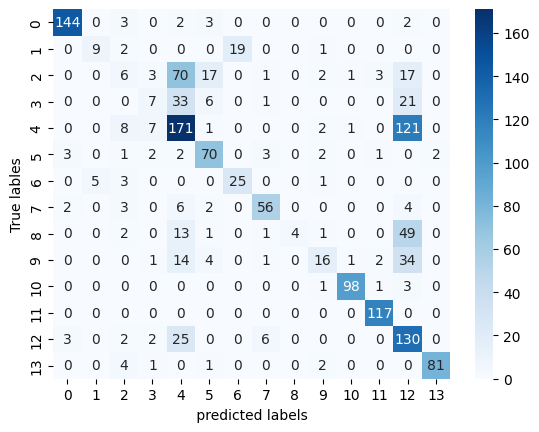

In [96]:
#Matrice de confusion
#Sue l'axe des coordonnées les True labels
#Sur l'axe des abcisses les labels predicted

matrice_confusion = confusion_matrix ( y_test, y_test_predicted )
fig = sns.heatmap ( matrice_confusion, annot = True, fmt = 'd', cmap = 'Blues' )
fig.set_xlabel (' predicted labels ')
fig.set_ylabel ( 'True lables' )

In [ ]:
proba_predictions = model_decision_tree.predict_proba (X_test )
proba_predictions

array([[0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.        , ..., 0.11111111, 0.11111111,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.4       ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
#Top 3 accuracy du model
from top_accuracy_V0 import top_accuracy

In [ ]:
classes = [ 0, 2, 16, 21, 22, 23, 30, 31, 32, 33 ]
print ( 'Top 3 accuracy du model decision tree :',  top_accuracy ( proba_predictions, np.array (y_test), classes, top_i = 3 ))

total =  1488
top 3  = 1387
Top 3 accuracy du model decision tree 93.21236559139786


|Visualisation de l'arbre de decision|
----------------------------------

In [39]:
#Profondeur de l'arbre 
print ( '''profondeur de l'arbre : ''', model_decision_tree.tree_.max_depth )

profondeur de l'arbre :  32


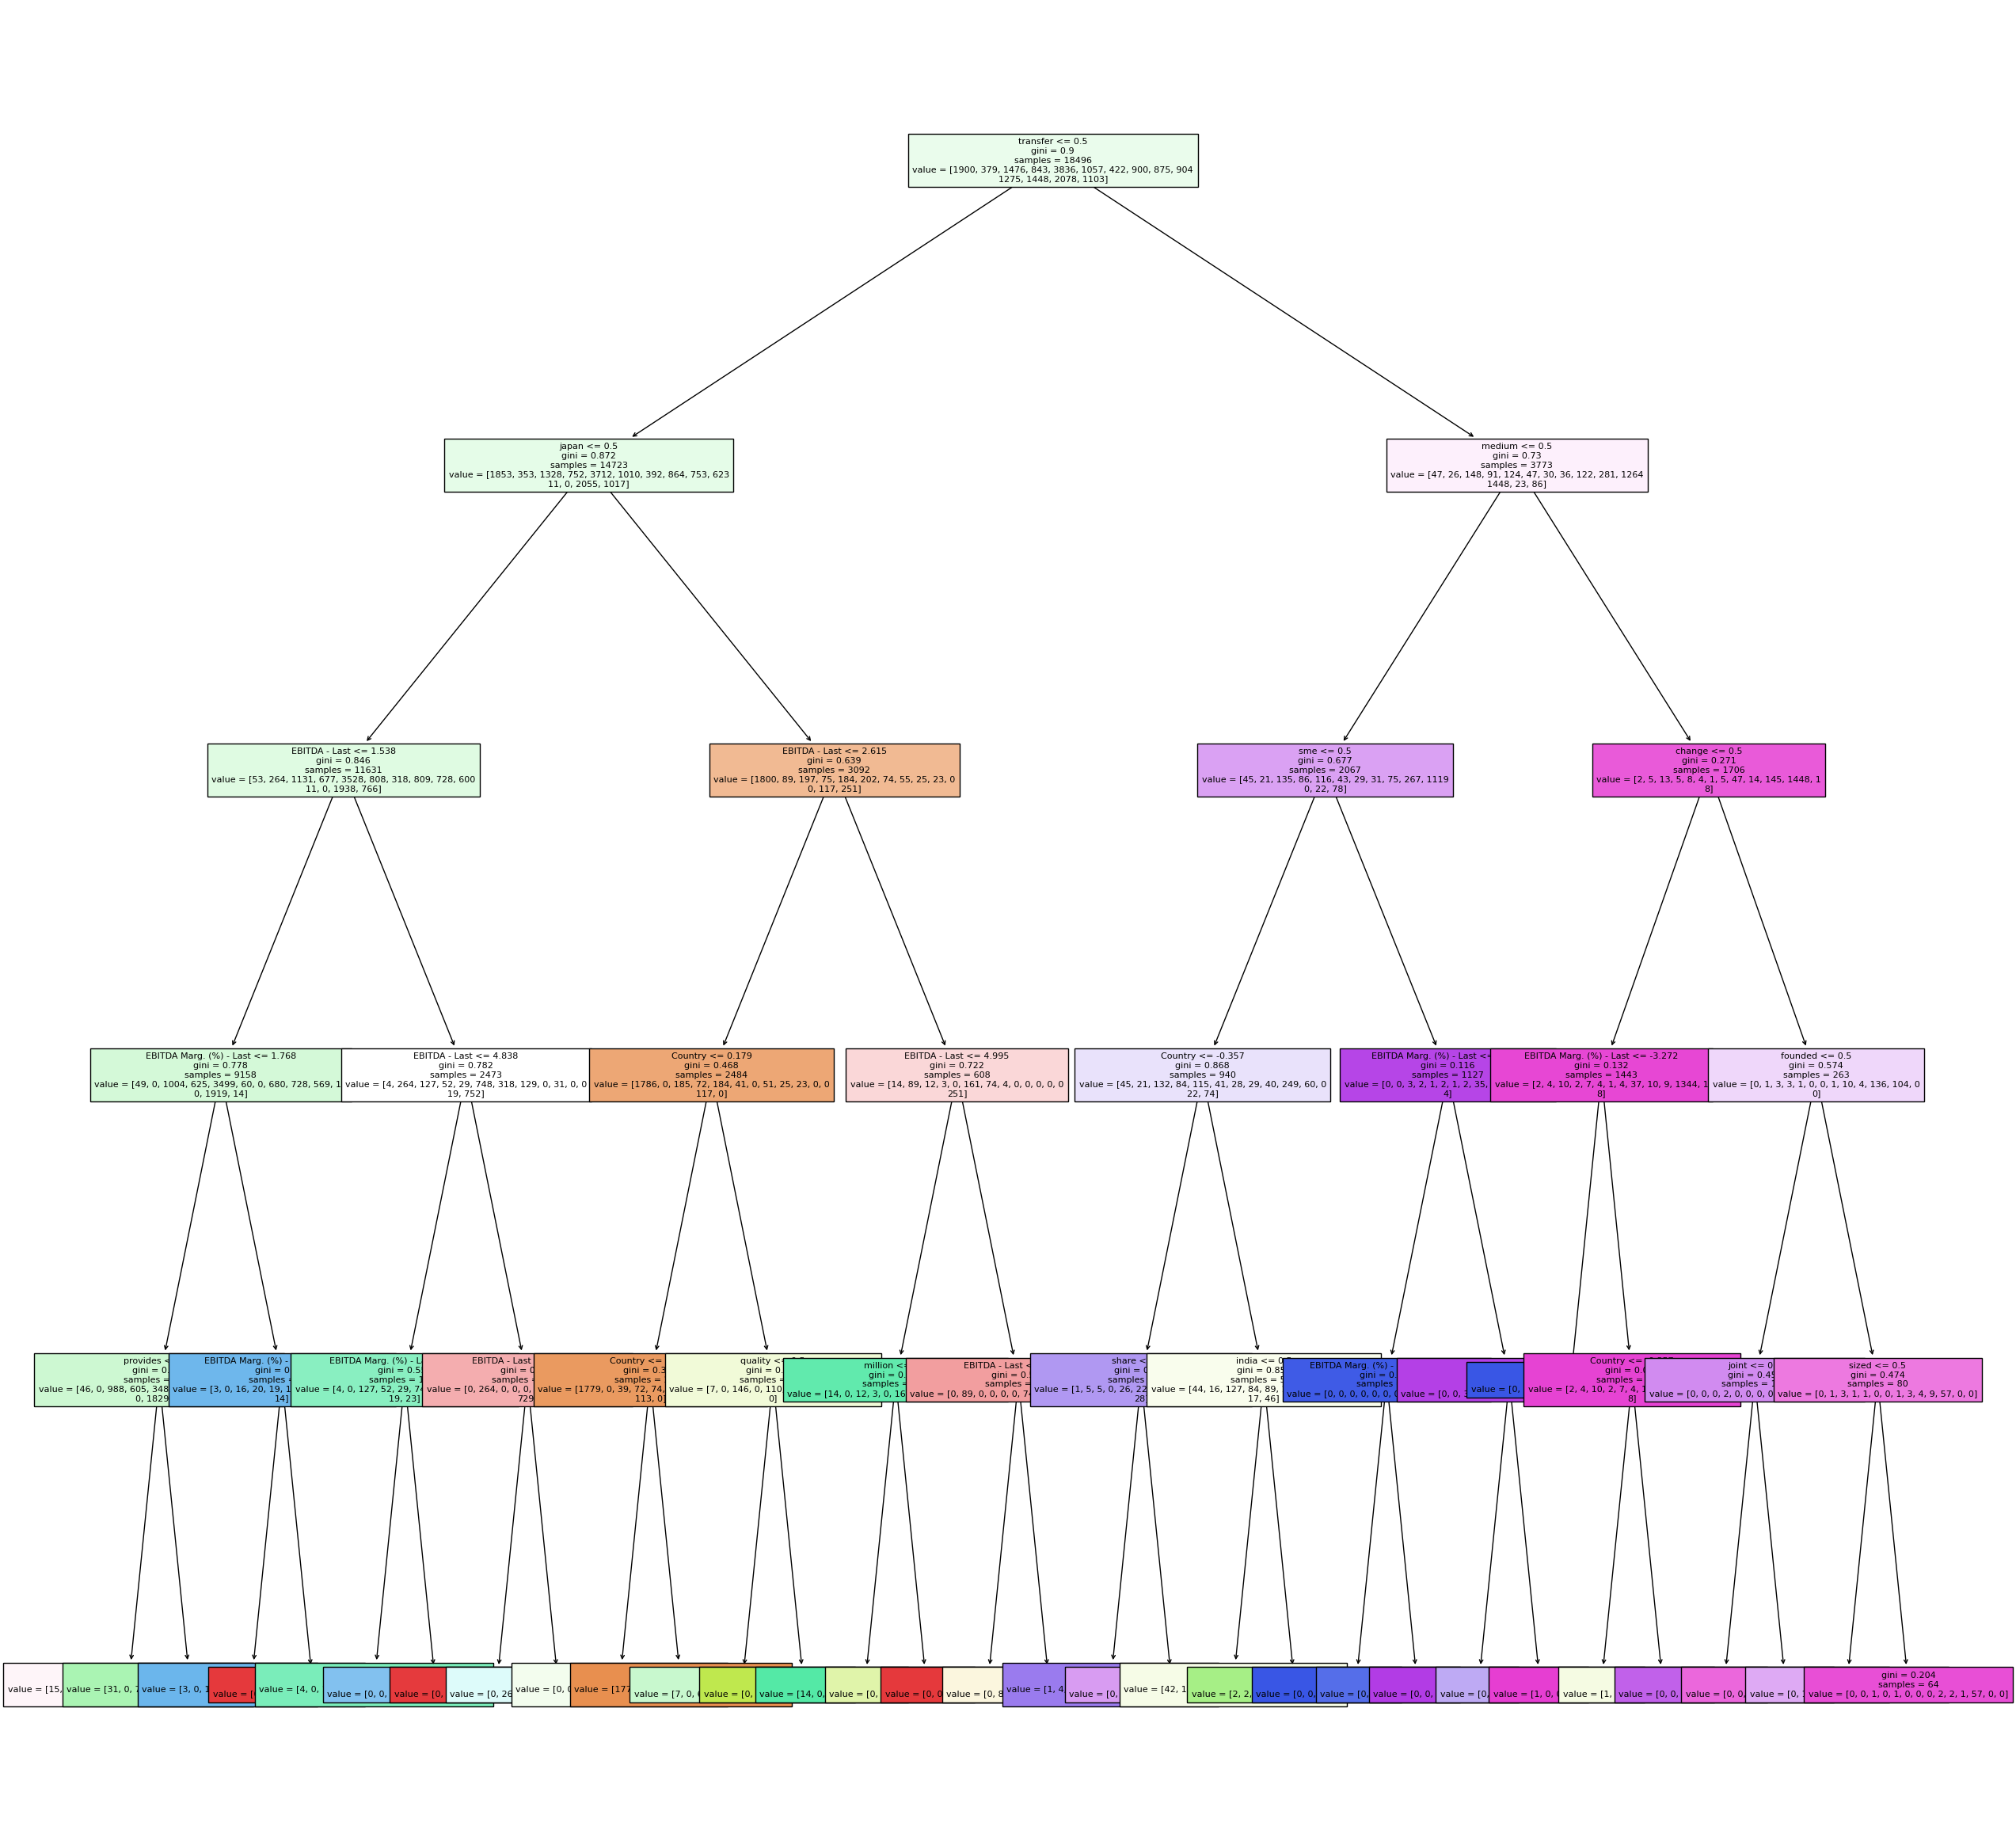

In [98]:
#Visualisation de l'arbre 
plt.figure(figsize=(30, 30))
plot_tree(model_decision_tree , feature_names=list(map(str, X_train.columns)), filled=True, max_depth = 6,  fontsize= 8)
plt.savefig ( 'Data Finpack/Decision_Tree.png' )

#### Deep Learning | Neural Networks | using Tensorflow | (Meilleures résultats)

|Initialisation du model|
---------------------

In [39]:
y_train.unique()

array([10,  7, 11,  4,  1, 12,  3,  9,  8, 13,  5,  6,  0,  2],
      dtype=int64)

In [2]:
#Initialisation du modèle 
num_unit1 = 100
num_unit2 = 200
num_unit3 = 200
num_unit4 = 100
taux_drop_out1 = 0
taux_drop_out2 = 0.2
model_DNN = keras.models.Sequential ( name = 'Dense_Neural_Networks' )
#Input layer
model_DNN.add ( layers.Input ( (2002,), name = ' Input_layer ' ) )
#hidden layer 1
model_DNN.add ( layers.Dense ( num_unit1 , activation = 'sigmoid', kernel_regularizer=regularizers.L2(0.01), name = 'Hidden_layer1' ) )
#hidden layer 2
model_DNN.add ( layers.Dropout( taux_drop_out2 ) )
model_DNN.add ( layers.Dense ( num_unit2 , activation = 'sigmoid',  name = 'Hidden_layer2' ) )
#hidden layer 3
model_DNN.add ( layers.Dense ( num_unit3 , activation = 'sigmoid',  name = 'Hidden_layer3' ) )
#hidden layer 4
model_DNN.add ( layers.Dense ( num_unit4 , activation = 'sigmoid', name = 'Hidden_layer4' ) )
#Output layer
model_DNN.add ( layers.Dense ( 14 , activation = 'softmax', name = 'Output_layer' ) )


#X_train.shape[1] y_train.value_counts().count()

In [3]:
#Propréités du model
model_DNN.compile ( optimizer = 'Adam',
                    loss = 'sparse_categorical_crossentropy',
                    metrics = ['accuracy'] )

In [4]:
#Récaputiatif du model
model_DNN.summary()

Model: "Dense_Neural_Networks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer1 (Dense)       (None, 100)               200300    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 Hidden_layer2 (Dense)       (None, 200)               20200     
                                                                 
 Hidden_layer3 (Dense)       (None, 200)               40200     
                                                                 
 Hidden_layer4 (Dense)       (None, 100)               20100     
                                                                 
 Output_layer (Dense)        (None, 14)                1414      
                                                                 
Total params: 282,214
Trainable params: 282,2

In [166]:
#Learning Rate Schedule
def schedule ( epoch ):
    if epoch < 100:
        return 0.001
    else:
        return 0.0001


In [167]:
#Entrainnement du model
hist = model_DNN.fit ( X_train, y_train,
                       epochs = 200,
                       batch_size = 64,
                       callbacks = keras.callbacks.LearningRateScheduler ( schedule ),
                       validation_data = ( X_validation, y_validation ) )

Epoch 1/200
289/289 [==============================] - 5s 11ms/step - loss: 2.4871 - accuracy: 0.2262 - val_loss: 2.0196 - val_accuracy: 0.3008 - lr: 0.0010
Epoch 2/200
289/289 [==============================] - 3s 10ms/step - loss: 1.7453 - accuracy: 0.3885 - val_loss: 1.5400 - val_accuracy: 0.4551 - lr: 0.0010
Epoch 3/200
289/289 [==============================] - 3s 10ms/step - loss: 1.5707 - accuracy: 0.4404 - val_loss: 1.4723 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 4/200
289/289 [==============================] - 3s 9ms/step - loss: 1.5196 - accuracy: 0.4624 - val_loss: 1.4259 - val_accuracy: 0.5054 - lr: 0.0010
Epoch 5/200
289/289 [==============================] - 3s 9ms/step - loss: 1.4928 - accuracy: 0.4779 - val_loss: 1.3734 - val_accuracy: 0.5284 - lr: 0.0010
Epoch 6/200
289/289 [==============================] - 3s 9ms/step - loss: 1.4200 - accuracy: 0.5188 - val_loss: 1.2414 - val_accuracy: 0.6045 - lr: 0.0010
Epoch 7/200
289/289 [==============================] - 3s 10m

|Overfeating|
-----------

In [168]:
#La df crossentropy
epoch = range(1, len(hist.history['loss']) + 1)
crossentropy = pd.DataFrame ( { 'epoch' : epoch, 'crossentropy_train' : hist.history['loss'], 'crossentropy_validation' : hist.history['val_loss'] } )

#Evolution de la fonction objective -crossentropy- en fonction du nombre d'epochs
fig2 = px.line ( crossentropy, x = 'epoch', y = [ 'crossentropy_train', 'crossentropy_validation' ], width = 1300, height = 600 )
fig2.update_layout ( title = '''Evolution de la fonction objective -crossentropy- en fonction du nombre d'epochs ''' )
fig2.show()

In [169]:
#La df de l'accuracy
epoch = range(1, len(hist.history['accuracy']) + 1)
accuracy = pd.DataFrame ( { 'epoch' : epoch, 'accuracy_train' : hist.history['accuracy'], 'accuracy_validation' : hist.history['val_accuracy'] } )

#Evolution de l'accuracy en fonction du nombre d'epochs
fig3 = px.line ( accuracy, x = 'epoch', y = [ 'accuracy_train', 'accuracy_validation' ], width = 1300, height = 600 )
fig3.update_layout ( title = '''Evolution de l'accuracy en fonction du nombre d'epochs ''' )
fig3.show()

|Performance du modèle|
--------------------

In [170]:
#Les probabilités de prédiction
y_train_predicted_proba = model_DNN.predict ( X_train )
#y_train prédit
y_train_predicted = np.argmax (y_train_predicted_proba, axis = 1)
print ( 'y_train :', y_train )
print ( 'y_train_predicted :', y_train_predicted )

578/578 [==============================] - 2s 4ms/step
y_train : 48659    10
19008     7
46608    10
57991    11
60433     4
         ..
6739      4
77650     4
62822     3
5049      4
78020     8
Name: labels, Length: 18496, dtype: int64
y_train_predicted : [ 9  7 10 ...  3  4  8]


In [53]:
y_train_predicted_proba [0]

array([2.4959113e-06, 1.2988276e-14, 4.7582216e-11, 8.7893354e-10,
       1.0371255e-05, 6.0024384e-08, 1.9565260e-17, 2.3828086e-09,
       1.7364691e-03, 7.8602833e-01, 1.8831937e-01, 1.5549993e-04,
       2.3747372e-02, 1.5181678e-10], dtype=float32)

In [171]:
print ( 'accuracy_score sur les données dentrainnemnet :', accuracy_score ( y_train, y_train_predicted ) )

accuracy_score sur les données dentrainnemnet : 0.9648572664359861


In [172]:
#accuracy sur les données de cross validation
y_validation_proba = model_DNN.predict ( X_validation )

y_validation_pred = np.argmax ( y_validation_proba, axis = 1 )
print ( 'accuracy sur les données validation', accuracy_score (y_validation, y_validation_pred) )

44/44 [==============================] - 0s 4ms/step
accuracy sur les données validation 0.9461593682699211


In [176]:
#Les probabilités de prédictions
y_test_predicted_proba = model_DNN.predict ( X_test )

#y_test_predicted
y_test_predicted = np.argmax ( y_test_predicted_proba, axis = 1 )

print ( 'y_test :', y_test )
print ( 'y_test_predicted :', y_test_predicted )

47/47 [==============================] - 0s 4ms/step
y_test : 77733    12
47291    10
60117    12
51176     4
72629    13
         ..
76948     4
71574    12
74294     0
35766     4
47049     1
Name: labels, Length: 1498, dtype: int64
y_test_predicted : [12 10 12 ...  0  4  1]


In [177]:
accuracy_test = accuracy_score ( y_test, y_test_predicted )
print ( 'accuracy_score sur les données test :', accuracy_test)

accuracy_score sur les données test : 0.9385847797062751


Text(0.5, 1.0, 'Matrice de confusion du model DNN')

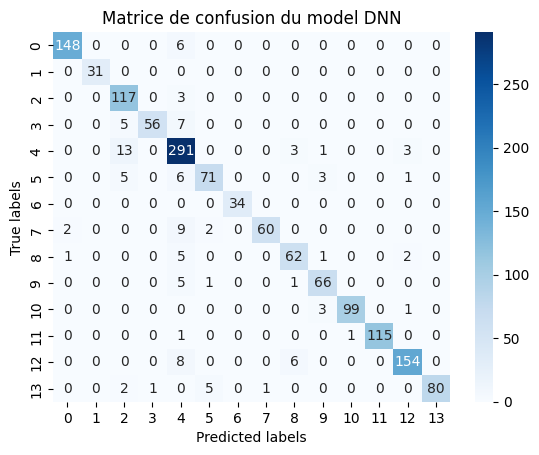

In [72]:
matrice_confusion = confusion_matrix ( y_test, y_test_predicted )
fig5 = sns.heatmap ( matrice_confusion, annot = True, fmt = 'd', cmap = 'Blues' )
fig5.set_xlabel ( 'Predicted labels' )
fig5.set_ylabel ( 'True labels' )
fig5.set_title ('Matrice de confusion du model DNN')

In [60]:
#Sauvegard de la figure
#fig5.figure.savefig( 'confusion_matrix_model_DNN.png' )

In [179]:
print ( 'F1_score du model DNN sur les données test :', f1_score ( y_test, y_test_predicted, average = 'macro' ) )

F1_score du model DNN sur les données test : 0.9410064785903085


In [131]:
#Top 3 accuracy du modèle 
from top_accuracy_V1 import top_accuracy 

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
top_accuracy (y_test_predicted_proba, np.array (y_test), classes, top_i = 3   )

total =  1498
top 3  = 1495


99.79973297730307

|La courbe ROC|
--------------

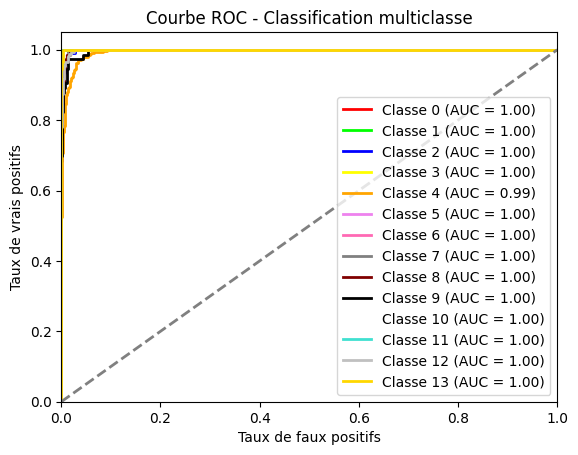

In [133]:
#Initialisation des taux

taux_vraies_positives = dict()
taux_faux_positives = dict()
roc_auc = dict ()

#Calcule des taux vraies positives et taux faux positives
for i in range(len(y_test_predicted_proba[0])):
    taux_faux_positives[i], taux_vraies_positives[i], _ = roc_curve(y_test, y_test_predicted_proba[:, i], pos_label=i)
    roc_auc[i] = auc( taux_faux_positives[i], taux_vraies_positives[i] )


#ploting figure
plt.figure()
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FFA500', '#EE82EE', '#FF69B4', '#808080', '#800000', '#000000', '#FFFFFF', '#40E0D0', '#C0C0C0', '#FFD700']  # Couleurs pour chaque classe
for i in range(len(y_test_predicted_proba[0])):
    plt.plot( taux_faux_positives[i], taux_vraies_positives[i], color=colors[i], lw=2, label='Classe %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Classification multiclasse')
plt.legend(loc="lower right")
plt.show()

In [134]:
roc_auc

{0: 0.9998695500927643,
 1: 1.0,
 2: 0.9986998064828253,
 3: 0.999331550802139,
 4: 0.9948775182374978,
 5: 0.9994235456881218,
 6: 0.9999397299903569,
 7: 0.9993366979091565,
 8: 0.9989044286743587,
 9: 0.9973371785628455,
 10: 0.9997842502696872,
 11: 0.9999381100032801,
 12: 0.9989079842463301,
 13: 0.9998724093109305}

In [160]:
#Historique des models DNN
Models = {}

In [162]:
#Enregistrement de l'historique des modeles
Models['Model'] = [model_DNN]
Models['accuracy_test'] = [accuracy_test]
Models['num_unit1'] = [num_unit1]
Models['num_unit2'] = [num_unit2]
Models['num_unit3'] = [num_unit3]
Models['num_unit4'] = [num_unit4]
Models['taux_drop_out1'] = [taux_drop_out1]
Models['taux_drop_out2'] = [taux_drop_out2]
Models

{'Model': [<keras.engine.sequential.Sequential at 0x23bb7316f50>],
 'accuracy_test': [0.9312416555407209],
 'num_unit1': [100],
 'num_unit2': [100],
 'num_unit3': [100],
 'num_unit4': [100],
 'taux_drop_out1': [0],
 'taux_drop_out2': [0.2]}

|Exportation du model|
-----------

In [136]:
#Importation du model
with open ( 'Models_V2/Model_DNN_comparable_classification.pkl', 'wb' ) as f:
    pickle.dump( model_DNN, f )

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-06-23 16:57:57         2485
metadata.json                                  2023-06-23 16:57:57           64
variables.h5                                   2023-06-23 16:57:57      5215240


#### Model NN using Torch

In [ ]:
#Transformons X_train et y_train, X_test, y_test en tenseurs 
X_train_tenseur = torch.tensor( X_train.values, dtype = torch.float32 )
y_train_tenseur = torch.tensor( y_train.values, dtype = torch.long )
X_validation_tenseur = torch.tensor( X_validation.values, dtype = torch.float32 )
y_validation_tenseur = torch.tensor( y_validation.values, dtype = torch.long )
X_test_tenseur = torch.tensor( X_test.values, dtype = torch.float32 )
y_test_tenseur = torch.tensor ( y_test.values, dtype = torch.long  )
X_train_tenseur

tensor([[  0.1379,   0.7463,  -0.1216,  ...,   0.0000,   0.0000,   0.0000],
        [  0.9310,  -0.6119,   0.4865,  ...,   0.0000,   0.0000,   0.0000],
        [  0.1379,   0.0597,   0.3919,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0896, -15.9865,  ...,   0.0000,   0.0000,   0.0000],
        [  0.1379,   0.4030,  -0.8378,  ...,   0.0000,   0.0000,   0.0000],
        [ -0.4138,   0.4179,   0.1081,  ...,   0.0000,   0.0000,   0.0000]])

In [240]:
#La classe model torch
class model_torch (nn.Module):
    def __init__ ( self, input_size, hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, output_size, dropout_rate):
        super ( model_torch, self ).__init__()
        self.fct1 = nn.Linear ( input_size, hidden_layer1_size )
        self.sigmoid = nn.Sigmoid()
        self.fct2 = nn.Linear (hidden_layer1_size, hidden_layer2_size)
        self.dropout = nn.Dropout (dropout_rate)
        self.fct3 = nn.Linear ( hidden_layer2_size, hidden_layer3_size )
        self.fct4 = nn.Linear ( hidden_layer3_size, output_size )

    def forward( self, X):
        z1 = self.fct1 (X)
        a1 = self.sigmoid(z1)
        a1_ = self.dropout (a1)
        z2 = self.fct2(a1_)
        a2 = self.sigmoid (z2)
        z3 = self.fct3 (a2)
        a3 = self.sigmoid (z3)
        yhat = self.fct4(a3)
        return yhat

In [241]:
#Initialisation du model
size_layer1 = 100
size_layer2 = 100
size_layer3 = 100
dropout_rate = 0.1
model_torchNN = model_torch ( X_train.shape[1],  size_layer1, size_layer2, size_layer3, len (y_train.unique()), dropout_rate )

|`Weight_decay controle la régularization. Une valeur élevée signifie une régularization forte et verse versa. valeur par défaut 0`|
-----------------------------

In [242]:
#Propriètées du model
learning_rate = 0.001
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam (model_torchNN.parameters(), lr = learning_rate, weight_decay = 0.001 )

In [243]:
#Entrainnement du model
num_epoch = 100
train_batch_size = 164
num_batches = X_train_tenseur.shape [0] // train_batch_size
validation_batch_size = X_validation_tenseur.shape[0] // num_batches
loss_train = []
loss_validation = []
print ( 'num_batches = ', num_batches )
print ('train_batch_size =', train_batch_size)
print ('validation_batch_size =', validation_batch_size)

for epoch in range (num_epoch):
    for batch in range (num_batches):
        #Forward propagation
        yhat_train = model_torchNN ( X_train_tenseur [batch*train_batch_size : (batch + 1)*train_batch_size] )
        yhat_validation = model_torchNN ( X_validation_tenseur [batch*validation_batch_size : (batch + 1)*validation_batch_size] )

        #loss
        loss_train.append (loss_function ( yhat_train, y_train_tenseur [batch*train_batch_size : (batch + 1)*train_batch_size] ))
        loss_validation.append (loss_function ( yhat_validation, y_validation_tenseur [batch*validation_batch_size : (batch + 1)*validation_batch_size] ))

        #Initialisation des gradient à 0
        optimizer.zero_grad()

        #backpropagation
        loss_train[-1].backward ()
        optimizer.step()

    print ( 'terminé pour le epoch :', epoch )

num_batches =  112
train_batch_size = 164
validation_batch_size = 12
terminé pour le epoch : 0
terminé pour le epoch : 1
terminé pour le epoch : 2
terminé pour le epoch : 3
terminé pour le epoch : 4
terminé pour le epoch : 5
terminé pour le epoch : 6
terminé pour le epoch : 7
terminé pour le epoch : 8
terminé pour le epoch : 9
terminé pour le epoch : 10
terminé pour le epoch : 11
terminé pour le epoch : 12
terminé pour le epoch : 13
terminé pour le epoch : 14
terminé pour le epoch : 15
terminé pour le epoch : 16
terminé pour le epoch : 17
terminé pour le epoch : 18
terminé pour le epoch : 19
terminé pour le epoch : 20
terminé pour le epoch : 21
terminé pour le epoch : 22
terminé pour le epoch : 23
terminé pour le epoch : 24
terminé pour le epoch : 25
terminé pour le epoch : 26
terminé pour le epoch : 27
terminé pour le epoch : 28
terminé pour le epoch : 29
terminé pour le epoch : 30
terminé pour le epoch : 31
terminé pour le epoch : 32
terminé pour le epoch : 33
terminé pour le epoch :

In [238]:
len (loss_train)

11200

In [239]:
loss_train_values = []
for i in range (0, len(loss_train), 100 ):
    loss_train_values.append (loss_train[i].item())
px.line ( x = range (len(loss_train_values)), y = loss_train_values )

In [202]:
#Evaluation du model
with torch.no_grad():
    #accuracy train
    outputs_train = model_torchNN ( X_train_tenseur )
    _, y_train_predicted = torch.max ( outputs_train.data, 1 )
    accuracy_train = accuracy_score ( y_train_tenseur, y_train_predicted )

    #accuracy test
    outputs_test = model_torchNN ( X_test_tenseur )
    _, y_test_predicted = torch.max ( outputs_test.data, 1 )
    accuracy_test = (y_test_predicted == y_test_tenseur).sum().item() / len( y_test_tenseur )

print ( 'accuracy sur les données dentrainnement :', accuracy_train )
print ('accuracy sur les données test :', accuracy_test)
    

accuracy sur les données dentrainnement : 0.9890091952772185
accuracy sur les données test : 0.9307795698924731


In [ ]:
print ( 'F1_score :', f1_score ( y_test_tenseur, y_test_predicted, average = 'macro' ) )

F1_score : 0.7536567937522042


#### Utilisation du model

In [128]:
#Importation du model
with open ( 'Model_DNN_comparable_classification.pkl', 'rb' ) as f:
    model = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-06-06 17:21:30         2485
metadata.json                                  2023-06-06 17:21:30           64
variables.h5                                   2023-06-06 17:21:30      2726440
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars


In [166]:
#Application du model sur l'exemple i
i = 620
exem = X_test.iloc [i:i+1]
label = y_test.iloc[i:i+1]
label

9741    4
Name: labels, dtype: int64

In [167]:
yhat = model.predict (exem)
yhat = np.argmax (yhat, axis =1)
yhat.tolist()

1/1 [==============================] - 0s 52ms/step


[4]

In [135]:
accuracy_score ( y_validation, yhat )

0.9501445086705202